# Lunar Phases and Cryptocurrency Returns

We obtain preliminary results investigating the relation between lunar phases and cryptocurrency returns. Our findings show that trading guided by  moon phases — namely, buying at a full moon phase and selling at the next new moon phase — shows significantly higher returns than other baseline methods. Further, we show an even stronger sinusoidal relationship between the moon phase in which we begin two-week trading (approximate length of half a moon cycle) and cryptocurrency market returns. We show that highest returns are achieved when we buy at a full moon phase and sell at a new moon phase, implying these phases map to local bottoms and tops, [something that has long been hypothesized](https://twitter.com/marenaltman/status/1427292474523881483?s=20&t=NhDoyOIzXYU75ZmdoHPo8w).

In [582]:
import bisect
import glob
import numpy as np
import pandas as pd
import pylunar
import re
import seaborn as sns
import statsmodels.formula.api as smf
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.precision", 4)

In [583]:
SECONDS_IN_DAY = 86400

# Data

## Collecting data
We consider the top 30 cryptocurrency tokens, by marketcap, listed on CoinGecko on Aug. 14, 2022, not including stablecoins or wrapped tokens. The data was gathered using the [CoinGecko API](https://www.coingecko.com/en/api). The script used to call the API is in this directory `./collect_data.py`.

In [584]:
DF_MAIN = pd.concat([pd.read_csv(fname) for fname in glob.glob("./data/CoinGecko_*.csv")])

## Cleaning data

We remove rows where either marketcap is zero or total volume is zero. This usually indicates to very early data, near a tokens listing.

In [585]:
# clean ticker symbol
DF_MAIN['ticker'] = [tkr.split('|')[0] for tkr in DF_MAIN['ticker']]

# remove rows where market cap or volume is 0
for col in ['market_caps', 'total_volumes']:
    print('Removing {} rows where `{}` == 0'.format(
        (DF_MAIN[col] == 0).sum(), col
    ))
    DF_MAIN = DF_MAIN[DF_MAIN[col] != 0]
    
# the data *should* contain consecutive days
# sometimes this data is missing, so we put NaNs in place
# this makes later computations much simpler
def fill_missing(df):
    df.sort_values('unixtime', inplace=True)
    ts_start = df.iloc[0].unixtime
    ts_end = df.iloc[-1].unixtime
    tss = range(ts_start, ts_end, SECONDS_IN_DAY)
    missing = set(tss) - set(df.unixtime)
    data = []
    for ts in missing:
        data.append([
            ts,
            datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'),
            df.iloc[0].ticker, np.nan, np.nan, np.nan
        ])
    return pd.DataFrame(data, columns=df.columns)

DF_MAIN = pd.concat([
    DF_MAIN.groupby('ticker').apply(fill_missing).reset_index(drop=True),
    DF_MAIN
]).reset_index(drop=True)

# get latest marketcaps and sort tickers by that,
# preseving unixtime sorting
custom_dict = {
    v: k
    for (k, v) in enumerate(
        DF_MAIN.groupby('ticker').last().total_volumes.sort_values(ascending=False).index
    )
}
DF_MAIN = DF_MAIN.sort_values(
    by='ticker',
    key=lambda x: x.map(custom_dict)
).groupby('ticker', sort=False).apply(
    lambda x: x.sort_values('unixtime')
).reset_index(drop=True)

Removing 443 rows where `market_caps` == 0
Removing 637 rows where `total_volumes` == 0


In [586]:
DF_MAIN

,unixtime,date,ticker,prices,market_caps,total_volumes
0,1388102400,2013-12-27 01:00:00,BTC,734.270,"8,944,473,292.000","62,881,800.000"
1,1388188800,2013-12-28 01:00:00,BTC,738.810,"9,002,769,255.000","28,121,600.000"
2,1388275200,2013-12-29 01:00:00,BTC,726.470,"8,855,251,580.000","27,018,300.000"
3,1388361600,2013-12-30 01:00:00,BTC,760.520,"9,270,681,761.000","24,717,100.000"
4,1388448000,2013-12-31 01:00:00,BTC,755.160,"9,205,343,763.000","21,903,500.000"
...,...,...,...,...,...,...
47820,1658880000,2022-07-27 02:00:00,LEO,5.084,"4,764,746,448.096","1,970,945.047"
47821,1658966400,2022-07-28 02:00:00,LEO,5.178,"4,843,044,935.433","1,707,115.191"
47822,1659052800,2022-07-29 02:00:00,LEO,5.321,"4,965,723,084.313","1,898,325.579"
47823,1659139200,2022-07-30 02:00:00,LEO,5.181,"4,848,771,860.852","2,088,763.614"


## Augmenting Data

We compute the moon phase for each entry using [pylunar](https://pypi.org/project/pylunar/).

In [587]:
mi = pylunar.MoonInfo((51, 30, 36), (0, 7, 5)) # London, UK

def moon_phase_data(df):

    def _moon_phase(date_string):
        # example data string:
        # "2012-06-19 14:08:00"
        mi.update(tuple(map(int, re.split("-|\s+|:", date_string))))
        return mi.fractional_phase()

    moon_phases = df['date'].apply(_moon_phase)
    s = (moon_phases.shift(1) > moon_phases) & (moon_phases.shift(-1) > moon_phases)
    new_moon_idxs = s.index[s]

    def _moon_cycle(idx):
        return bisect.bisect(new_moon_idxs, idx)

    def _day_after_new_moon(idx):
        nearest_new_moon = new_moon_idxs[_moon_cycle(idx) - 1]
        result = idx - nearest_new_moon
        if result >= 0:
            return result
        return 30 - (new_moon_idxs[0] - idx)

    s1 = df.apply(lambda row: _moon_cycle(row.name),axis=1)
    s2 = df.apply(lambda row: _day_after_new_moon(row.name), axis=1)
    
    return pd.DataFrame({'moon_cycle': s1, 'days_after_new_moon': s2})

In [588]:
if 'moon_cycle' not in DF_MAIN.columns:
    DF_MAIN = DF_MAIN.join(DF_MAIN.groupby('ticker').apply(moon_phase_data))
DF_MAIN.head(10)

,unixtime,date,ticker,prices,market_caps,total_volumes,moon_cycle,days_after_new_moon
0,1388102400,2013-12-27 01:00:00,BTC,734.270,"8,944,473,292.000","62,881,800.000",0,25
1,1388188800,2013-12-28 01:00:00,BTC,738.810,"9,002,769,255.000","28,121,600.000",0,26
2,1388275200,2013-12-29 01:00:00,BTC,726.470,"8,855,251,580.000","27,018,300.000",0,27
3,1388361600,2013-12-30 01:00:00,BTC,760.520,"9,270,681,761.000","24,717,100.000",0,28
4,1388448000,2013-12-31 01:00:00,BTC,755.160,"9,205,343,763.000","21,903,500.000",0,29
5,1388534400,2014-01-01 01:00:00,BTC,767.740,"9,358,693,020.000","23,448,600.000",1,0
6,1388620800,2014-01-02 01:00:00,BTC,772.530,"9,417,082,760.000","16,837,800.000",1,1
7,1388707200,2014-01-03 01:00:00,BTC,825.470,"10,062,417,390.000","54,171,500.000",1,2
8,1388793600,2014-01-04 01:00:00,BTC,849.140,"10,350,952,914.000","36,344,700.000",1,3
9,1388880000,2014-01-05 01:00:00,BTC,919.410,"11,207,538,944.000","62,414,600.000",1,4


# Empirical Findings

## Summary Statistics

In [589]:
def cumulative_return(x):
    return (x.iloc[-1] - x.iloc[0]) / x.iloc[0]

def mean_monthly_log_return(x):
    df = pd.DataFrame({0: x, 1: x.shift(-30)})
    # use mask to mark the NaNs
    # so we can compute log over series
    a = df.to_numpy(dtype=float)
    a = np.ma.array(a, mask=np.isnan(a))
    return np.mean(np.log(a[:, 1] / a[:, 0]))

def std_monthly_log_return(x):
    df = pd.DataFrame({0: x, 1: x.shift(-30)})
    a = df.to_numpy(dtype=float)
    a = np.ma.array(a, mask=np.isnan(a))
    return np.std(np.log(a[:, 1] / a[:, 0]))

df = DF_MAIN.groupby("ticker").agg(
    start_date=('date', lambda x: x.values[0][:10]),
    no_obs=('date', lambda x: len(x)),
    cumulative_return=('prices', cumulative_return),
    mean_monthly_log_return=('prices', mean_monthly_log_return),
    std_monthly_log_return=('prices', std_monthly_log_return),
).sort_values('start_date')

df.style.format(formatter={
    "cumulative_return": "{:,.0%}",
    "mean_monthly_log_return": "{:.3f}",
    "std_monthly_log_return": "{:.2f}"
})

,start_date,no_obs,cumulative_return,mean_monthly_log_return,std_monthly_log_return
ticker,,,,,
XRP,2013-12-27,3141,"1,364%",0.027,0.45
LTC,2013-12-27,3141,169%,0.008,0.33
BTC,2013-12-27,3143,"3,121%",0.032,0.23
DOGE,2013-12-27,3141,"12,707%",0.048,0.47
XMR,2014-05-21,2996,"6,198%",0.042,0.37
XLM,2014-08-06,2919,"4,386%",0.040,0.46
ETH,2015-08-08,2552,"127,406%",0.083,0.39
ETC,2016-07-25,2200,"6,278%",0.033,0.40
BCH,2017-08-02,1827,-81%,-0.021,0.40


## Relationship between moon phase and returns

- We look at n-day trading (where n is 15, 30, 60) and ... we call this a cycle

- We shift the start of the cycle by one day

- We pick 30 & 60 since these correspond to buying and selling on the same moon phase. And if there is a moon phase effect, using these days should counteract any effect for any other n day period (e.g. 7, 14).

In [590]:
def _n_day_cumulative_returns(df, n):
    df = pd.DataFrame({0: df.prices, 1: df.prices.shift(-n)})
    #print(df)
    a = df.to_numpy(dtype=float)
    #print(a[:, 1] - a[:, 0])
    return pd.Series((a[:, 1] - a[:, 0]) / a[:, 0])

def _n_day_mean_daily_log_returns(df, n):
    df2 = pd.DataFrame({0: df.prices, 1: df.prices.shift(-1)})
    a = df2.to_numpy(dtype=float)
    a = np.ma.array(a, mask=np.isnan(a))
    daily_log = pd.Series(np.log(a[:, 1] / a[:, 0]), name='daily_log')
    return daily_log.index.to_series().apply(
        lambda x: np.mean(daily_log.iloc[x:x+n])
    )

In [593]:
for n in [14, 30, 60]:
    for fn in [_n_day_cumulative_returns, _n_day_mean_daily_log_returns]:
        key = '{}{}'.format(n, fn.__name__[2:])
        DF_MAIN[key] = DF_MAIN.groupby('ticker', sort=False).apply(lambda x: fn(x, n)).values

# 14-day returns vs moon phase of purchase date

We first look at 14-day trading cycles. That is, we consider the returns when we buy a token and then sell it 14 days later. Note that 14 days is the approximate length of half a moon cycle — there are ~29.5 days between consecutive new moons and there are ~14 days between a new moon and the next full moon. Here, our x-axis is the moon phase of the purchase date, represented as the number of days after the most recent new moon (0 - 28 days); i.e. 0 represents a new moon date and 28 is also approximately a new moon date.

Note that the majority of plots show a peak near the middle (approx. `x = 14`) which corresponds to trades where buys are executed at full moons (approx. 14 days after a new moon) and sells are executed at the following new moon. This is precisely what has been [hypothesized elsewhere](https://twitter.com/marenaltman/status/1427292474523881483?s=20&t=NhDoyOIzXYU75ZmdoHPo8w), namely that full moons indicate local bottoms and new moons indicate local tops.

Further, we observe what appears to a sinusoidal relationship between our returns and the distance of our purchase date from the nearest new moon. **This is tested and confirmed further down in the notebook.**

Also: We also plot the mean daily log returns for these in the appendix.

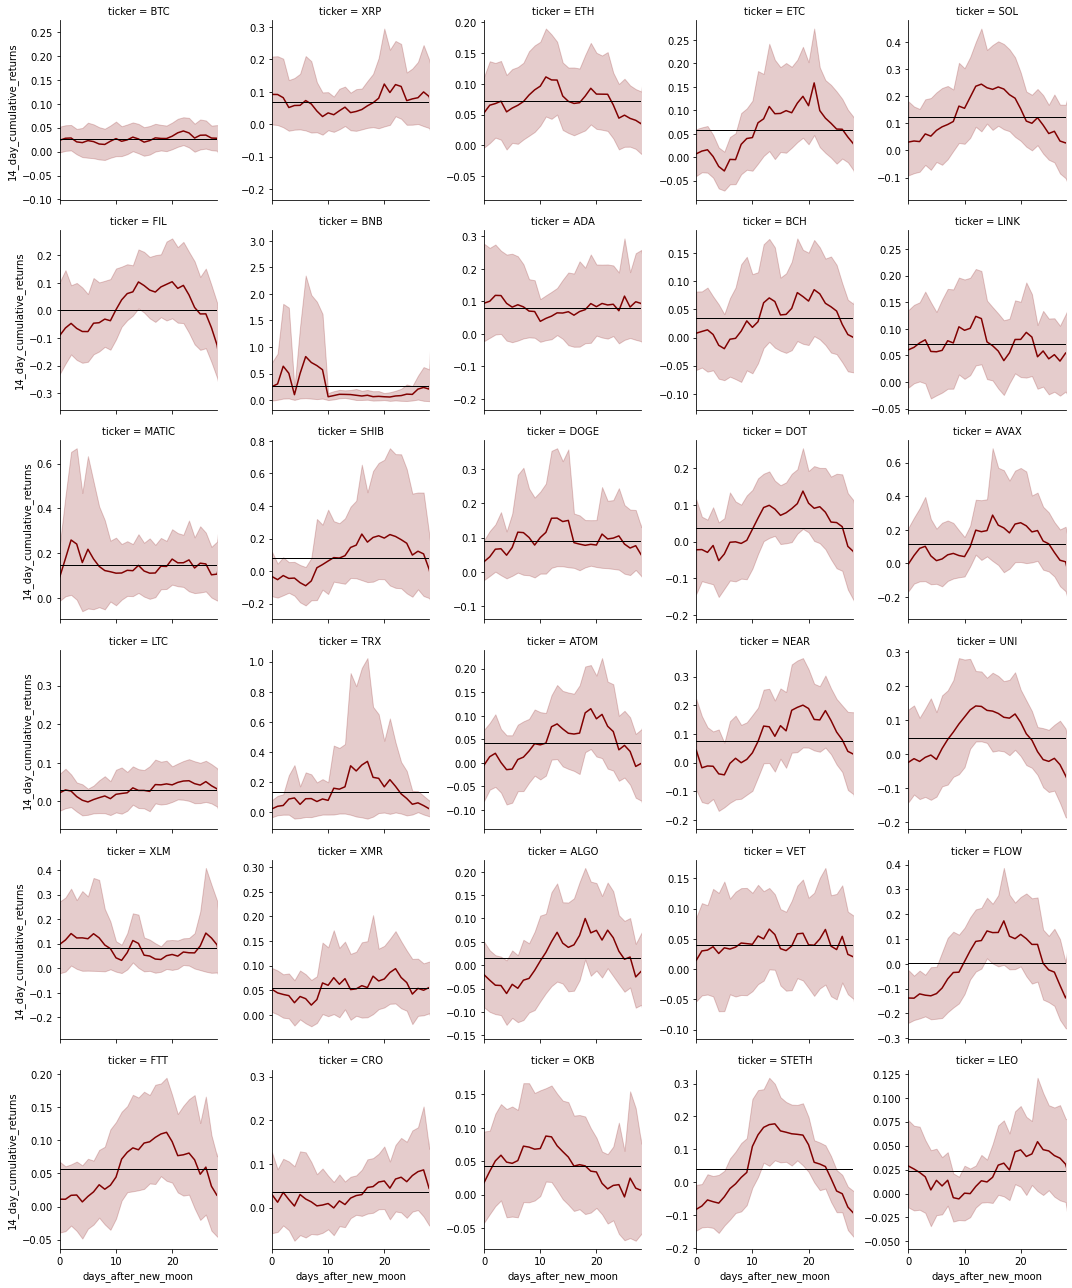

In [642]:
g = sns.FacetGrid(DF_MAIN, col="ticker", col_wrap=5, height=3, aspect=1, xlim=(0, 28), sharey=False)
g.set_axis_labels('')
g.map(sns.lineplot, "days_after_new_moon", "14_day_cumulative_returns", color='maroon');
g.map(lambda y, **kw: plt.axhline(y.mean(), color="k", linewidth=1), "14_day_cumulative_returns");
#g.set(title='Cumulative Returns on 14-day trades vs moon cycle (mean return marked as horizontal line)')
g.set_axis_labels("days_after_new_moon");

# 30-day returns vs moon phase of purchase date (a baseline)

As a bit of a visual baseline, we look at the same plots but with 29-day trading cycles; that is, we look at returns for trades where buy and sells occur at equal and consecutive phases of the moon. E.g. 0 on the x-axis represents cumulative returns where the buy and sell occur at consecutive new moons (29 days apart). 

Note that hardly any of the graphs display a sinusoidal pattern (like those above) and, in fact, are mostly flat. Again, this is formally tested later on. The visual difference between 14-day and 30-day cycle plots is even more stricking when looking at mean daily log returns (see Appendix).

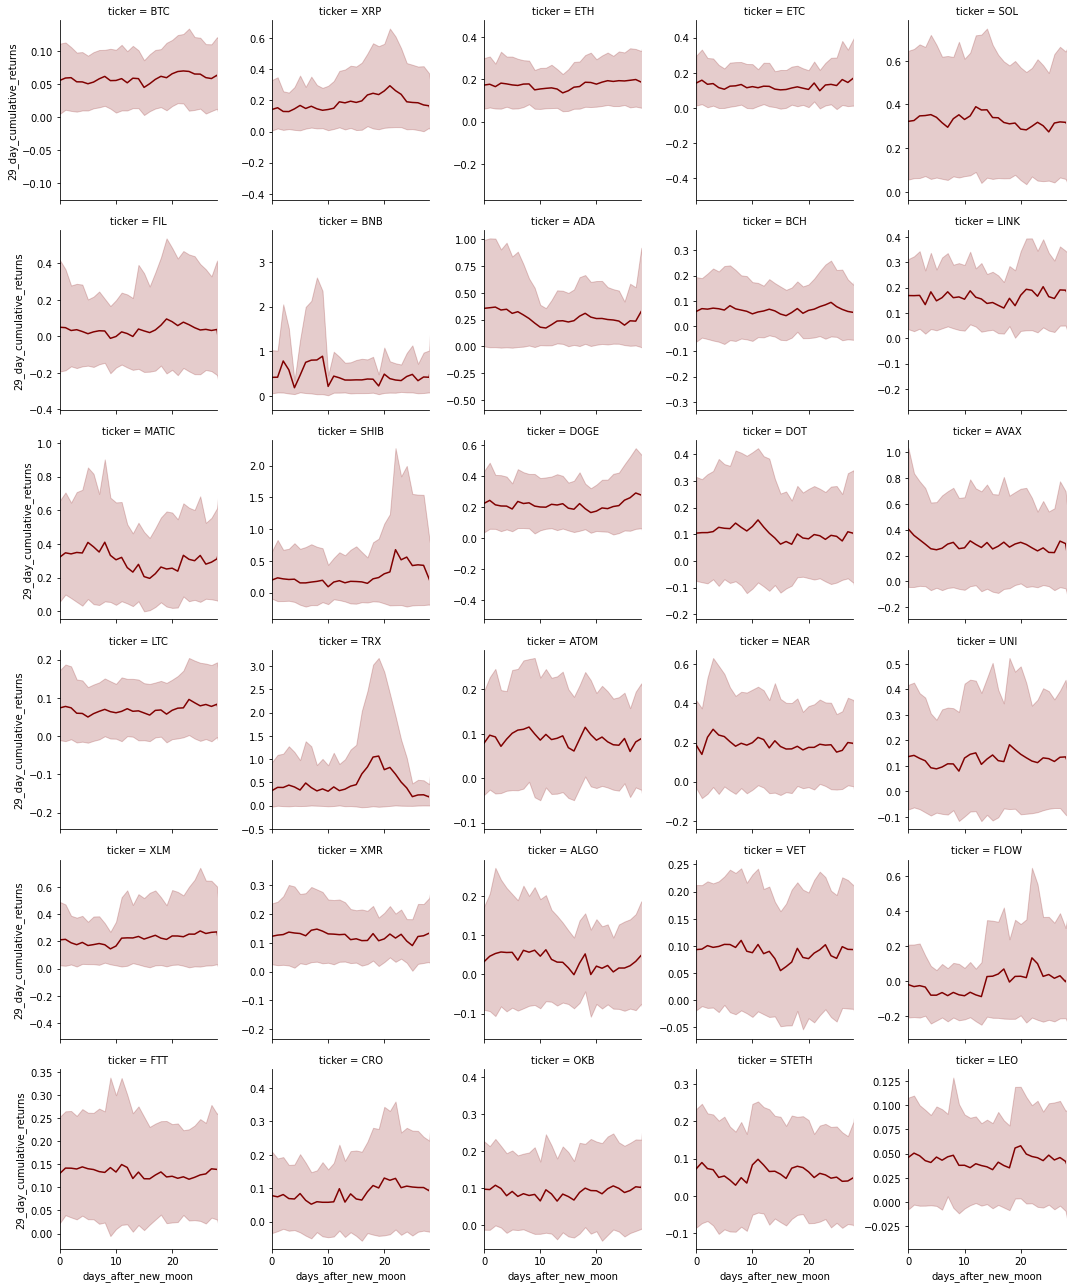

In [644]:
g = sns.FacetGrid(DF_MAIN, col="ticker", col_wrap=5, height=3, aspect=1, xlim=(0, 28), sharey=False)
g.map(sns.lineplot, "days_after_new_moon", "29_day_cumulative_returns", color='maroon');

# Formally testing sinusoidal relationship
A sinusoidal model is also estimated to test for the cyclical pattern of the lunar effect.
According to this model, the lunar effect reaches its peak at the time of full moon and declines to
a trough at the time of new moon, following a cosine curve with a period of 29.53 days (the
mean length of a lunar cycle). The results indicate a significant cyclical lunar pattern in stock
    returns.  

In [566]:
def _run_experiment(df):
    result = []
    df['cos_trans'] = np.cos(2 * np.pi * df['days_after_new_moon'] / 29.53)
    for n in [15, 30, 60]:
        for fn in [_n_day_cumulative_returns, _n_day_mean_daily_log_returns]:
            key = '{}{}'.format(n, fn.__name__[2:])
            df[key] = fn(df, n).values
            reg = smf.ols('Q("{}") ~ cos_trans'.format(key), data=df).fit()
            result.extend([
                reg.params.cos_trans,
                reg.tvalues.cos_trans,
                reg.pvalues.cos_trans
            ])
    return pd.Series(result)

DF_RESULT = DF_MAIN.groupby('ticker', sort=False).apply(_run_experiment)
DF_RESULT.index=pd.Index(tickers, name='Ticker:')
DF_RESULT.columns = pd.MultiIndex.from_product([
      ['15 Day', '30 Day', '60 Day'],
      ['Cumulative', 'Mean Daily Log'],
      ['coef', 't', 'P>|t|']
    ], names=['Window:', 'Return:', 'Metric:']
)
#DF_RESULT

In [651]:
# just styling stuff; code hidden by default

multiindex = pd.MultiIndex.from_product([
      ['15 Day', '30 Day', '60 Day'],
      ['Cumulative', 'Mean Daily Log'],
      ['coef', 't', 'P>|t|']
])

s = DF_RESULT.style.format(formatter={
    t:(
        "{:.1f}" if t[2] == 't'
        else "{:.4f}" if t[2] == 'P>|t|'
        else "{:.4f}" if t[1] == 'Mean Daily Log'
        else "{:.2f}"
    )
    for t in multiindex
})

s.columns = pd.MultiIndex.from_product([
  ['15 Day', '30 Day', '60 Day'],
  ['Cumulative', 'Mean Daily Log'],
  ['coef', 't', 'P>|t|']
], names=['Window:', 'Return:', ''])

s.set_table_styles([
    {'selector': '.index_name', 'props': 'font-weight:normal; font-weight: normal;'},
    {'selector': 'th.row_heading', 'props': 'font-weight:bold; text-align: center;'},
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em; border-bottom: 1px solid darkgrey;'},
    {'selector': 'th.col_heading.level1', 'props': 'font-size: 1.2em; border-bottom: 1px solid darkgrey;'},
    {'selector': 'th.col_heading.level2', 'props': 'font-size: 1.2em; border-bottom: 1px solid darkgrey;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: normal;'},
    {'selector': 'th:not(.index_name)', 'props': 'background-color: black; color: white;'}
])

s.set_table_styles({
    ('30 Day', 'Cumulative', 'coef'): [
        {'selector': 'th', 'props': 'border-left: 2px solid white'},
        {'selector': 'td', 'props': 'border-left: 2px solid black'}
    ],
    ('60 Day', 'Cumulative', 'coef'): [
        {'selector': 'th', 'props': 'border-left: 2px solid white'},
        {'selector': 'td', 'props': 'border-left: 2px solid black'}
    ],
    ('15 Day', 'Mean Daily Log', 'coef'): [
        {'selector': 'td', 'props': 'border-left: 1px solid black'}
    ],
    ('30 Day', 'Mean Daily Log', 'coef'): [
        {'selector': 'td', 'props': 'border-left: 1px solid black'}
    ],
    ('60 Day', 'Mean Daily Log', 'coef'): [
        {'selector': 'td', 'props': 'border-left: 1px solid black'}
    ]
}, overwrite=False, axis=0)

def highlight_pvalues(s):
    def _color(pvalue):
        if pvalue < 0.001:
            return "FCF947"
        if pvalue < 0.01:
            return "FDFA75"
        if pvalue < 0.05:
            return "FEFDBA"
        if pvalue < 0.1:
            return "FFFEE8"
        else:
            return ""
    props = []
    for x in ['15 Day', '30 Day', '60 Day']:
        for y in ['Cumulative', 'Mean Daily Log']:
            pvalue = s[x, y, 'P>|t|']
            props.extend(['background-color:#{}'.format(_color(pvalue))] * 3)
    return props

s.apply(highlight_pvalues, axis=1)

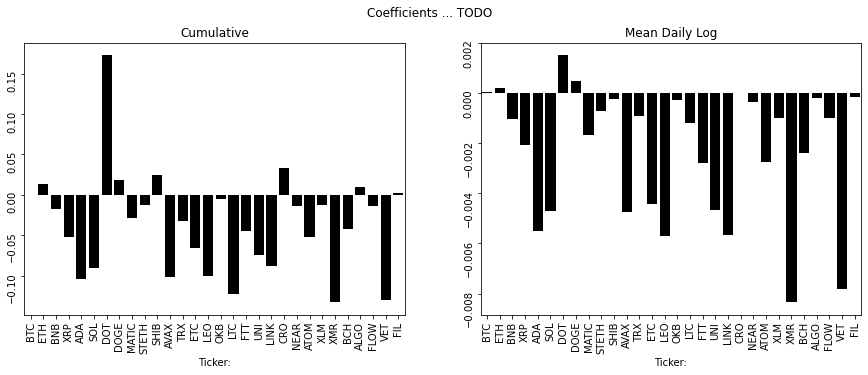

In [641]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)
fig.suptitle('Coefficients ... TODO')

df = DF_RESULT[('15 Day', 'Cumulative', 'coef')]
g1 = sns.barplot(x=df.index, y=df.values, color='black', ax=ax1);
g1.set_xticklabels([tkr.split('|')[0] for tkr in DF_RESULT.index]);
g1.set(title='Cumulative');

df = DF_RESULT[('15 Day', 'Mean Daily Log', 'coef')]
g2 = sns.barplot(x=df.index, y=df.values, color='maroon', ax=ax2);
g2.set_xticklabels([tkr.split('|')[0] for tkr in DF_RESULT.index]);
g2.set(title='Mean Daily Log');

#ax2.plot(x, -y)

# Appendix

Just some additional plots.

## 14-day (half moon cycle) mean daily log returns vs moon phase
Note: We mark the mean with a horizontal line.

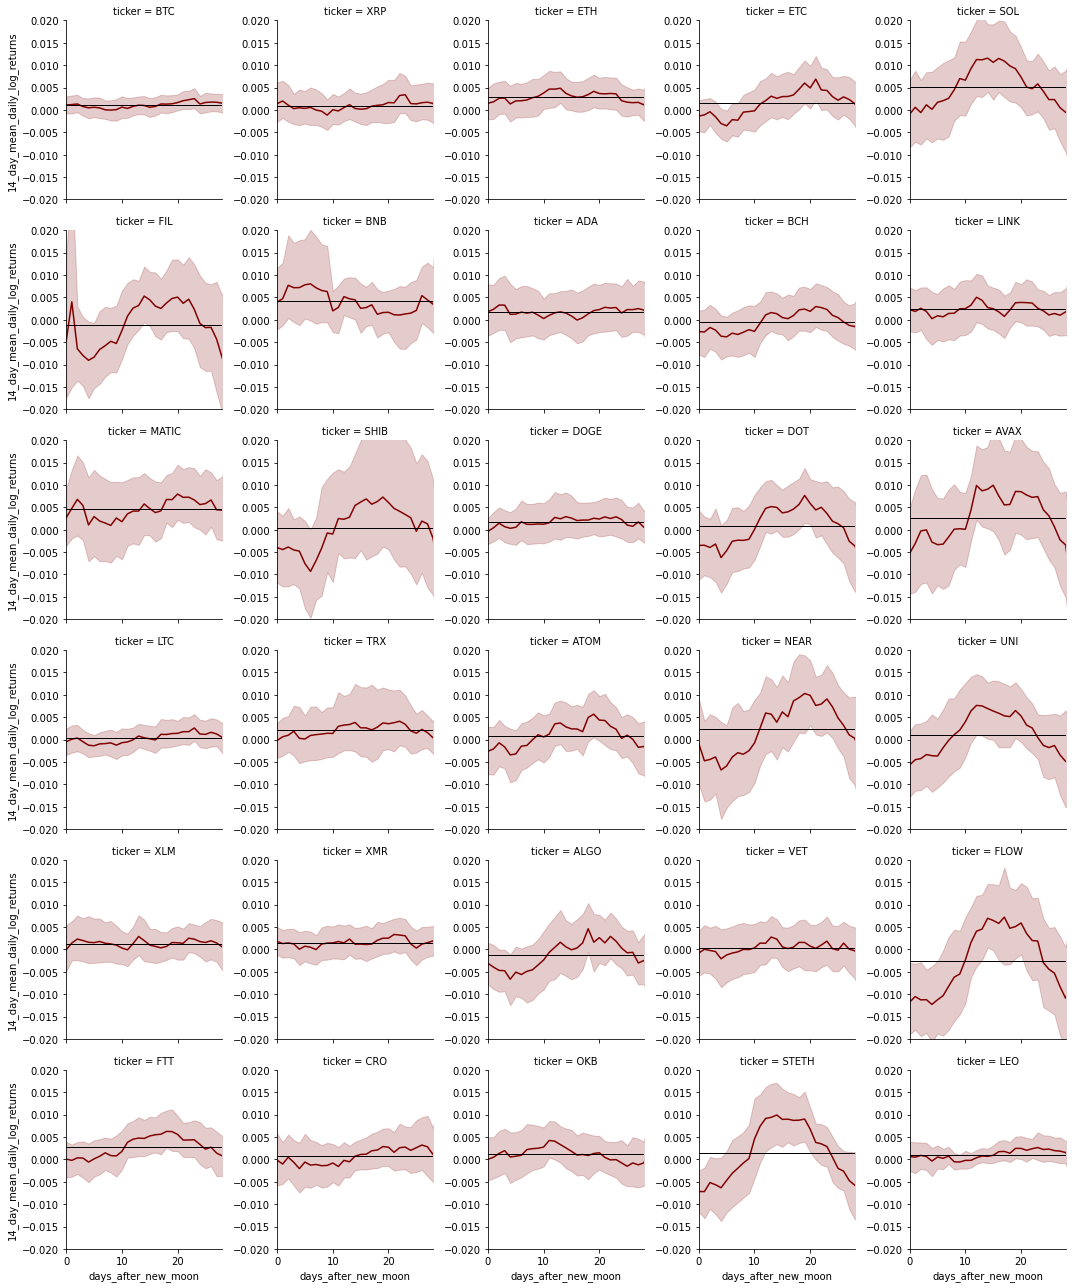

In [649]:
g = sns.FacetGrid(
    DF_MAIN, col="ticker", col_wrap=5, height=3, aspect=1,
    xlim=(0, 28), ylim=(-0.02, 0.02), sharey=False
)
g.map(sns.lineplot, "days_after_new_moon", "14_day_mean_daily_log_returns", color='maroon');
g.map(lambda y, **kw: plt.axhline(y.mean(), color="k", linewidth=1), '14_day_mean_daily_log_returns');
g.set_axis_labels("days_after_new_moon");

## 30-day (one moon cycle) mean daily log returns vs moon phase

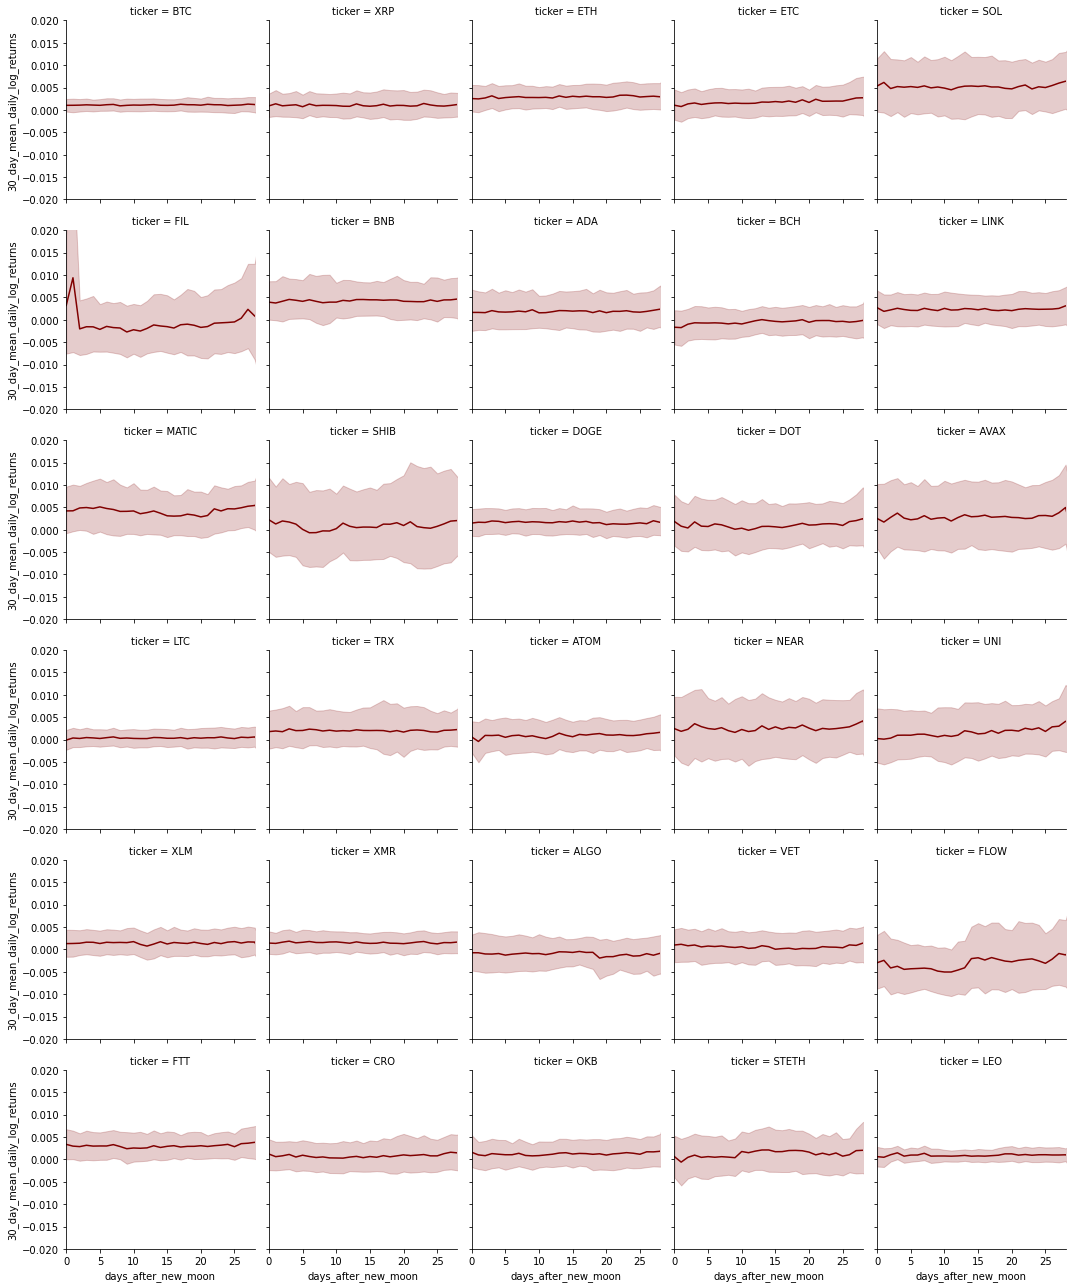

In [647]:
g = sns.FacetGrid(
    DF_MAIN, col="ticker", col_wrap=5, height=3, aspect=1,
    xlim=(0, 28), ylim=(-0.02, 0.02), sharey=True
)
g.map(sns.lineplot, "days_after_new_moon", "30_day_mean_daily_log_returns", color='maroon');

## 60-day (two moon cycles)  mean daily log returns vs moon phase

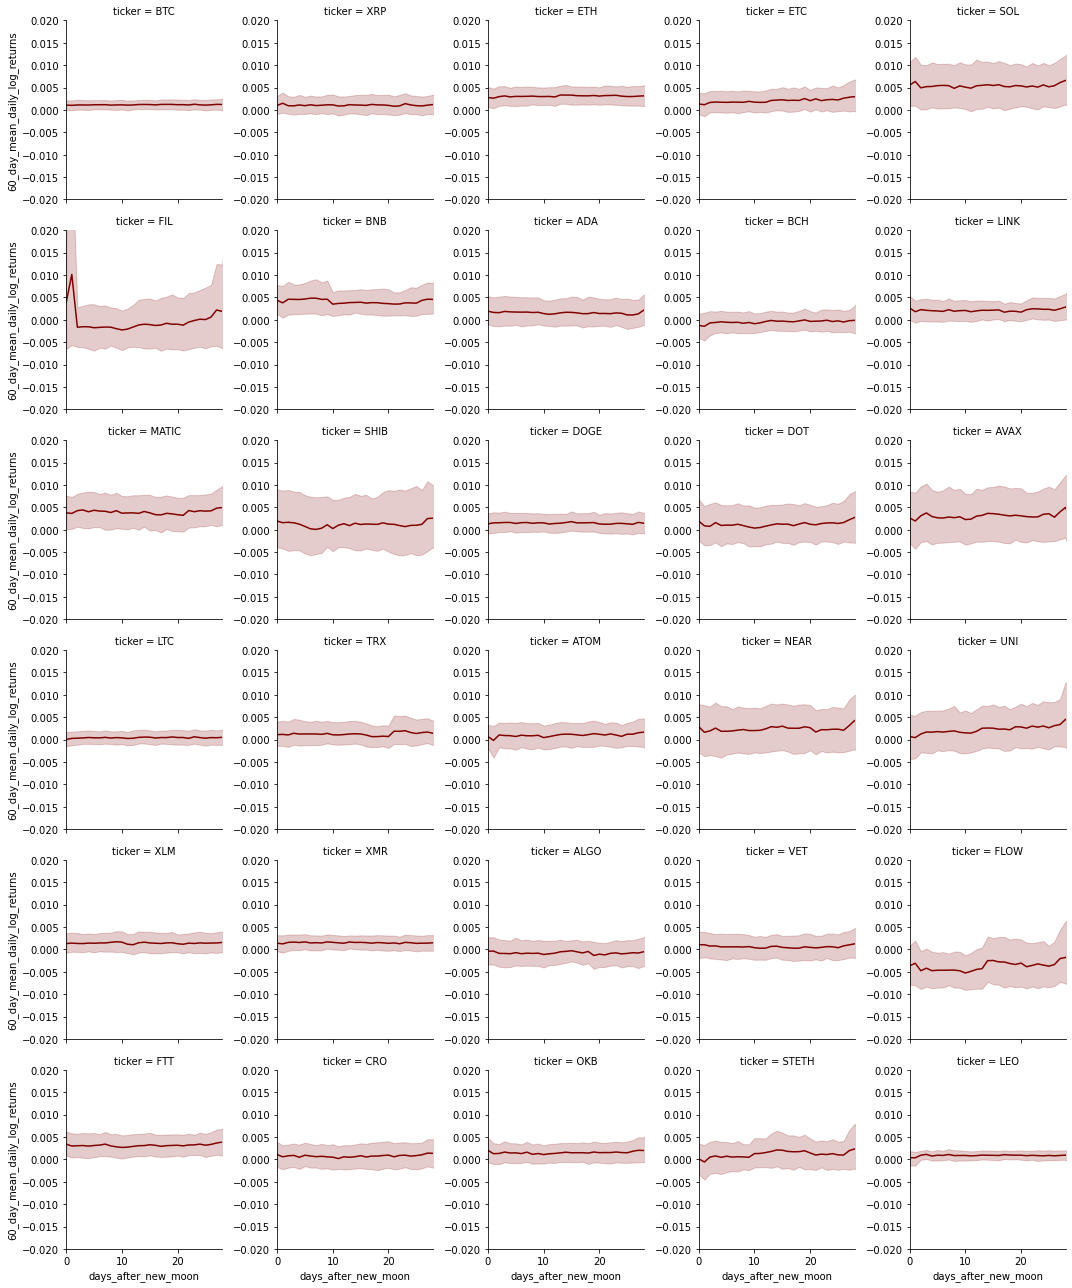

In [646]:
g = sns.FacetGrid(
    DF_MAIN, col="ticker", col_wrap=5, height=3, aspect=1,
    xlim=(0, 28), ylim=(-0.02, 0.02), sharey=False
)
g.map(sns.lineplot, "days_after_new_moon", "60_day_mean_daily_log_returns", color='maroon');